<a href="https://colab.research.google.com/github/ANANTHMANOJ/phenmonia_eda/blob/master/Basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building the Model from Scratch

Installing pydicom to read .pcd files

In [1]:
!pip3 install pydicom

     |████████████████████████████████| 35.5MB 90kB/s 


### Importing the library required for this project

In [2]:
import tensorflow as tf      # for building the model
import pandas as pd          # for reading the csv files
import numpy as np           # for basic mathematic functions
import pydicom as dicom      # to read the.dcm files
import os
import cv2
from pathlib import Path

 # for visualization proecess
import matplotlib.pyplot as plt     
from matplotlib.patches import Rectangle
import seaborn as sns

 # for saving and loading the model
import pickle
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor
import csv
import random
import keras
import pydicom
import shutil

# for defining the layers of the model
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as kera
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Checking the version of tensor flow

In [3]:
tf.__version__

'2.3.0'

Mounting the device for retriving and saving the data from google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/phemonia_capstone_eda/'
os.chdir(path)

Mounted at /content/drive


Using unzip command to retrieve the data from google drive, extract it in colab

In [6]:
!unzip '/content/drive/My Drive/phemonia_capstone_eda/rsna-pneumonia-detection-challenge.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: /content/stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: /content/stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  i

In [7]:
path='/content/'
os.chdir(path)

Method to store the patients id who are having pneumonia

In [8]:
pneumonia_locations = {}
# load table
with open('/content/stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

### Dividing the data into trian, validation and test set 

In [12]:

# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples


n train samples 24124
n valid samples 2560


"\n\ntrain_filenames = os.listdir('/content/train_data')\nvalid_filenames = os.listdir('/content/test_data')\nn_valid_samples = len(train_filenames)\nn_train_samples = len(valid_filenames)\n"

### Defining the generator class which gives the image and the respective mask of a patient

In [13]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = cv2.resize(img, (self.image_size, self.image_size))
        msk = cv2.resize(msk, (self.image_size, self.image_size)) 
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    

        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        # load files
        items = [self.__load__(filename) for filename in filenames]
        # unzip images and masks
        imgs, msks = zip(*items)
        # create numpy batch
        imgs = np.array(imgs)
        msks = np.array(msks)
        return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

 ### Defining matrices and loss fucntions
 - Matrices
  - Dice coefficient
  - Mean IOU
 <br>

- Loss 
 - img_loss
 - iou and bce loss

In [14]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numr = 2 * tf.reduce_sum(y_true*y_pred)
    denom = tf.reduce_sum(y_pred + y_true) 
    return numr/(denom + tf.keras.backend.epsilon())



from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def img_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [15]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

### Defining the model

The Basic model which was built from scratch includes combination of 2D convolution layers, Maxpooling layers and Conv2dTranspose layers, having final depth of 8 such combinations. The model uses relu as activation function, having 3x3 srtides , takes 256x256 sized image and uses Adam optimiser while compiling.


In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,LeakyReLU,UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [5]:
def model(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [6]:
model = model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Visualization of our model

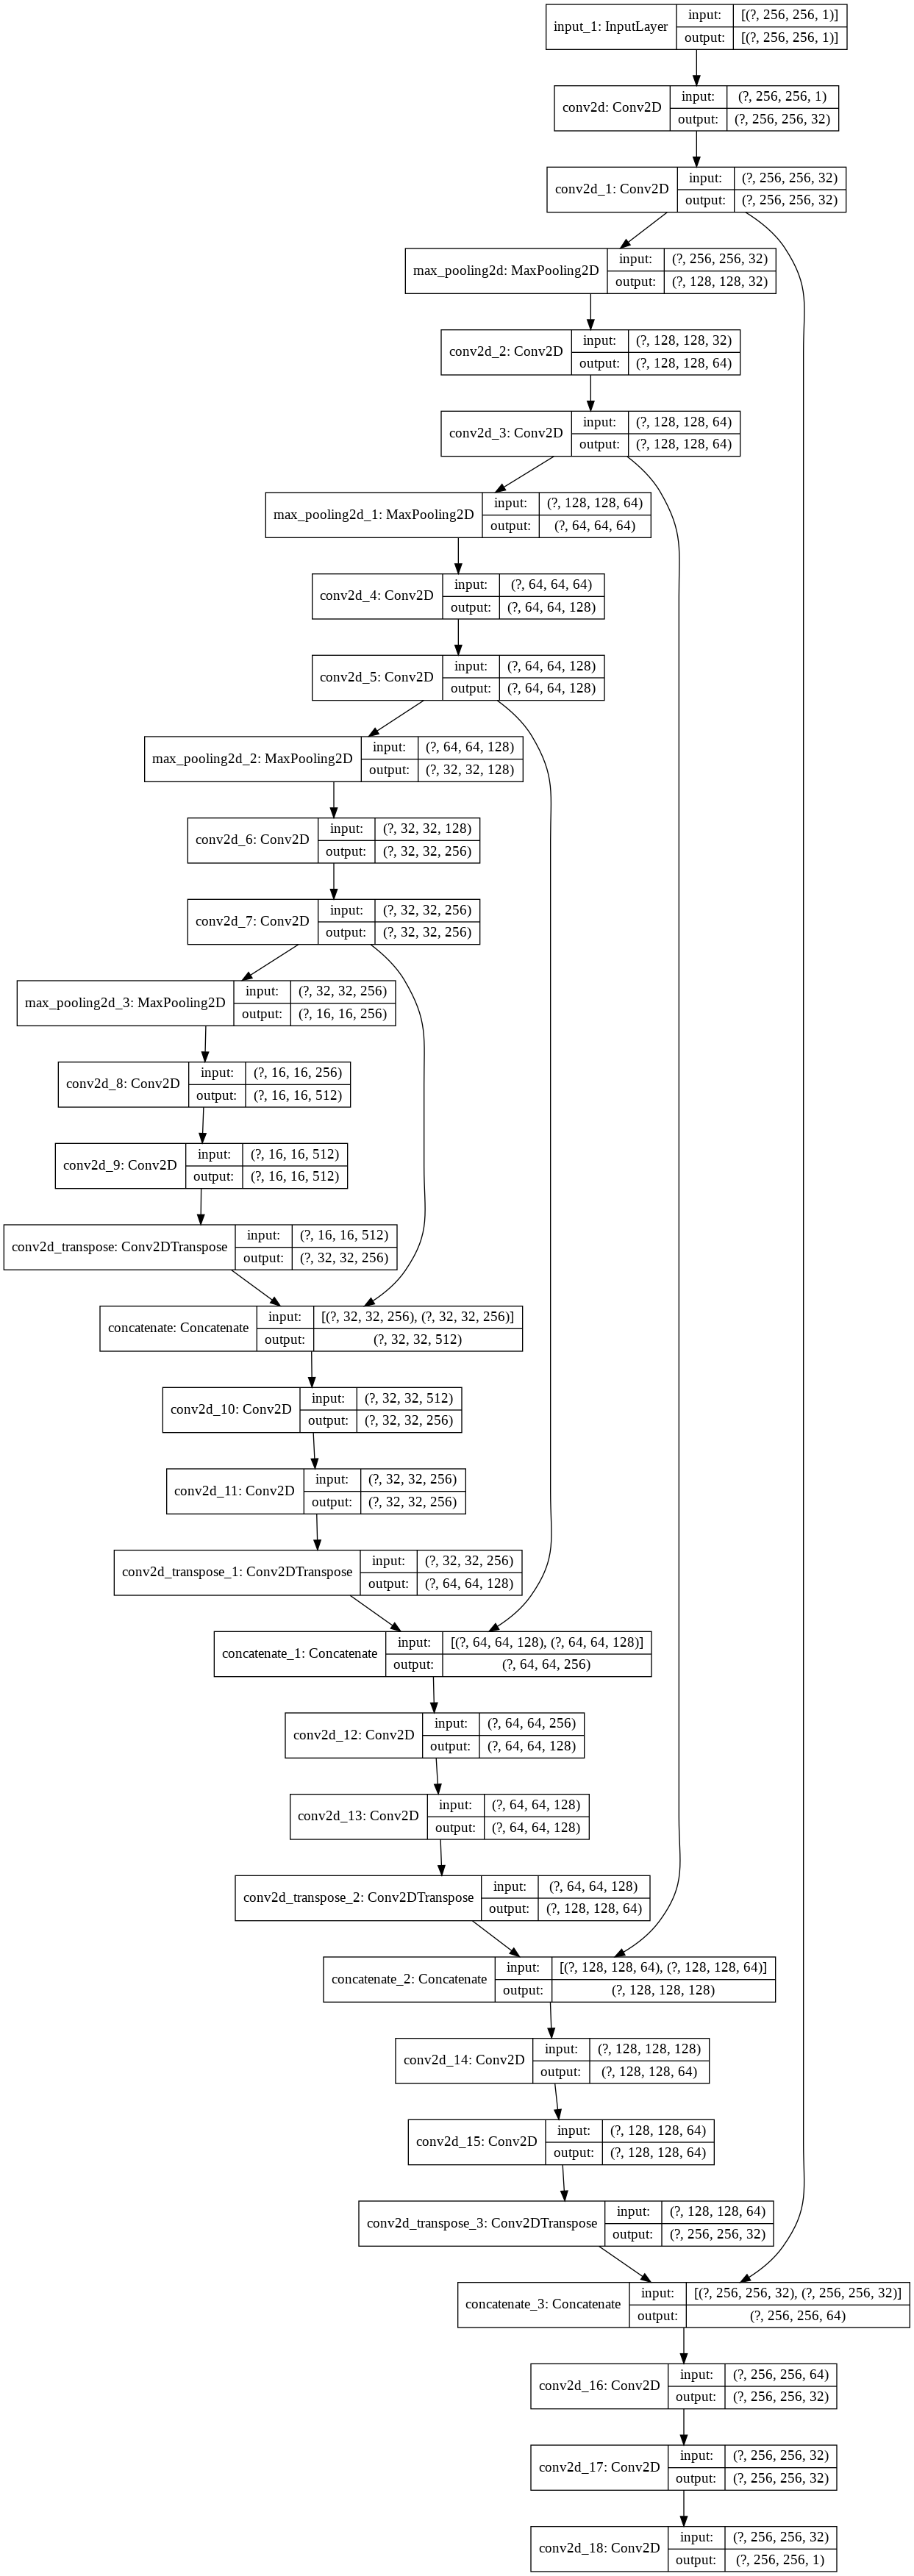

In [8]:
model_skeleton = '/content/model_skel.png'
tf.keras.utils.plot_model(model,to_file = model_skeleton,show_shapes=True)

Defining the cosine annealing function for learning rate

In [20]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.00001
    epochs = 50
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
    
reduced_lr = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#reduced_lr = ReduceLROnPlateau( monitor= 'val_accuracy',patience= 2, verbose= 1, factoar= 0.3, min_lr= 0.000001)

Using generator function to generate train and valid datas as required by the model

In [21]:
folder = '/content/stage_2_train_images'
folder_train = '/content/train_data'
folder_test = '/content/test_data'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True )
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True)

In [22]:
tf.config.run_functions_eagerly(True)

Compiling the model with adam optimizer

In [24]:
model.compile(optimizer=Adam(lr=1e-5), loss=img_loss,metrics=[dice_coefficient, 'binary_accuracy',mean_iou])

### Training the model

In [25]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[reduced_lr], epochs=50, shuffle=True,workers=10)

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
753/753 [==============================] - 338s 449ms/step - loss: 2.2350 - dice_coefficient: 0.1890 - binary_accuracy: 0.9299 - mean_iou: 0.1516 - val_loss: 1.4122 - val_dice_coefficient: 0.3046 - val_binary_accuracy: 0.9569 - val_mean_iou: 0.3354
Epoch 2/50
753/753 [==============================] - 339s 451ms/step - loss: 1.4788 - dice_coefficient: 0.2919 - binary_accuracy: 0.9555 - mean_iou: 0.3671 - val_loss: 1.2938 - val_dice_coefficient: 0.3333 - val_binary_accuracy: 0.9582 - val_mean_iou: 0.4147
Epoch 3/50
753/753 [==============================] - 339s 450ms/step - loss: 1.3751 - dice_coefficient: 0.3190 - binary_accuracy: 0.9583 - mean_iou: 0.4560 - val_loss: 1.3868 - val_dice_coefficient: 0.3294 - val_binary_accuracy: 0.9708 - val_mean_iou: 0.5567
Epoch 4/50
753/753 [==============================] - 340s 451ms/step - loss: 1.3037 - dice_coefficient: 0.3419 - binary_accuracy: 0.9612 - mean_iou: 0.5005 - val_loss: 1.4225 - val_dice_coefficient: 0.3133 - val_binary_

Libraries used for visualization

In [27]:
from skimage import measure
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

Predicting the bounding box

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(101, 51, 180, 116)
(102, 83, 103, 84)
(103, 205, 104, 206)
(105, 197, 106, 198)
(105, 206, 106, 207)
(106, 195, 107, 196)
(107, 156, 171, 206)
(109, 178, 110, 180)
(111, 205, 112, 206)
(114, 169, 115, 170)
(127, 203, 128, 204)
(140, 46, 196, 102)
(47, 41, 183, 103)
(78, 141, 120, 185)
(87, 182, 88, 183)
(91, 184, 92, 185)
(115, 179, 116, 180)
(116, 149, 117, 150)
(117, 153, 118, 154)
(117, 161, 118, 162)
(135, 141, 186, 189)
(142, 184, 143, 185)
(60, 39, 177, 99)
(90, 141, 208, 202)
(197, 192, 198, 193)
(50, 154, 133, 212)
(71, 163, 72, 164)
(73, 163, 74, 164)
(77, 151, 170, 200)
(120, 51, 167, 102)
(130, 101, 132, 102)
(166, 181, 168, 183)
(169, 165, 171, 167)
(54, 47, 189, 118)
(64, 102, 65, 103)
(87, 145, 200, 229)


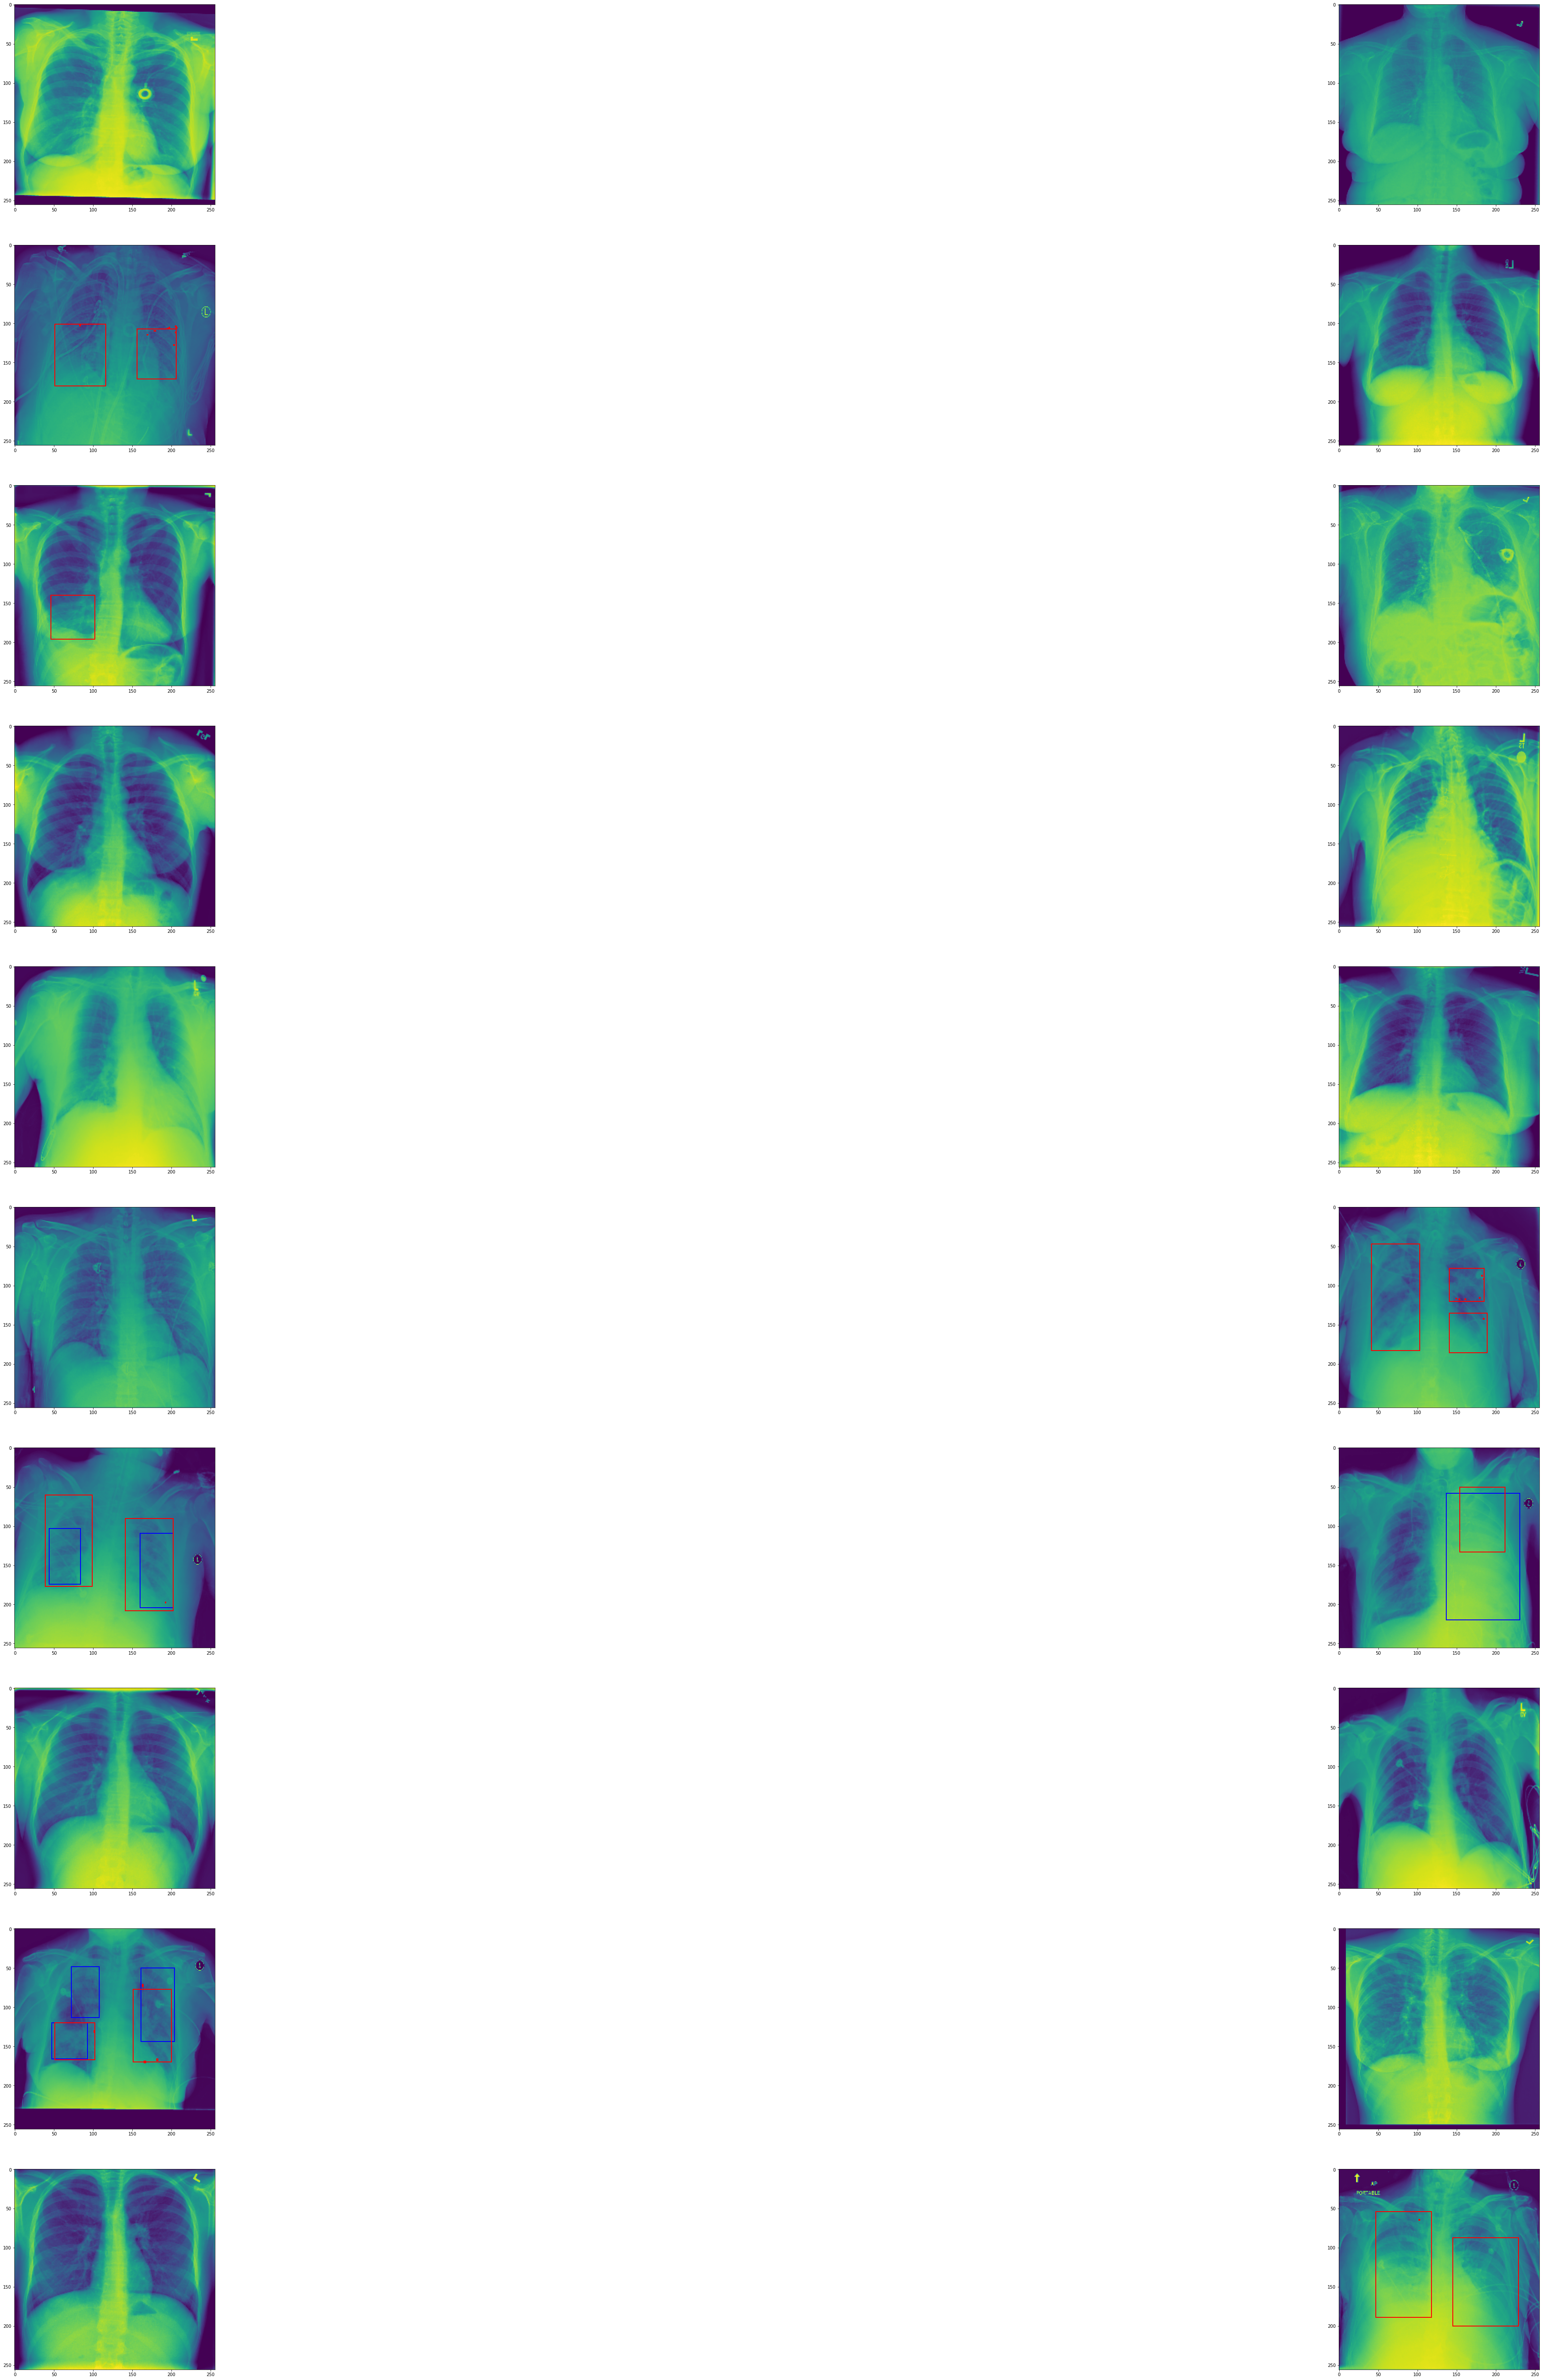

In [29]:

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks in train_gen:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(10, 2, figsize=(100, 100))
    axes = axes.ravel()
    axidx = 0
    
    # Loop through the batch
    for img, mask, prediction in zip(imgs, masks, predictions):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            print(region.bbox)
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        #axes[axidx].text(0.05, 0.95, f'Actual target: \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 20):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break


In [30]:



keys = pneumonia_locations.keys()
list1= list()
pn_file = list()
for i in keys:
  list1.append(i)
len(list1)

for i in range(32):
  pn_file.append(list1[i] + '.dcm')
  print(pn_file)


lt=os.listdir(path+'/stage_2_train_images')
i=0
for fily in lt:
  #pn_file= i
  pn_file.append(fily)
  print(pn_file)
  i+=1
  if(i>=32):
    break


testing_gen = generator(folder, pn_file, pneumonia_locations, batch_size=32, image_size=256, shuffle=True )


['00436515-870c-4b36-a041-de91049b9ab4.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', '00f08de1-517e-4652-a04f-d1dc9ee48593.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-49f4573b2dbb.dcm', '00aecb01-a116-45a2-956c-08d2fa55433f.dcm', '00c0b293-48e7-4e16-ac76-9269ba535a62.dcm', '00f08de1-517e-4652-a04f-d1dc9ee48593.dcm', '0100515c-5204-4f31-98e0-f35e4b00004a.dcm']
['00436515-870c-4b36-a041-de91049b9ab4.dcm', '00704310-78a8-4b38-8475-

In [ ]:

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks in testing_gen:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    axes = axes.ravel()
    axidx = 0
    
    # Loop through the batch
    for img, mask, prediction in zip(imgs, masks, predictions):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            print(region.bbox)
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        #axes[axidx].text(0.05, 0.95, f'Actual target: \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 15):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break


In [ ]:
print('Variation of loss and mean_iou for training and validation data.')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

Saving the model in drive

In [ ]:
config = model.get_config()
model.from_config(config)

In [ ]:
path='/content/drive/My Drive/phemonia_capstone_eda/saved_model_2'
os.chdir(path)

In [ ]:
model.save(path)

Function to load the model from drive

In [ ]:
def f1(y_true, y_pred):
    return 1
n_model= tf.keras.models.load_model('/content/drive/My Drive/phemonia_capstone_eda/saved_model_2',custom_objects={'f1':f1})
n_model